In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

In [2]:
tf.keras.utils.set_random_seed(1917) #For reproducibility

The code block below defines a few helper functions to visualize the results. You do not need to touch them.

In [3]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue).

In [4]:
# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


(<Figure size 1000x1000 with 100 Axes>, <Axes: >)

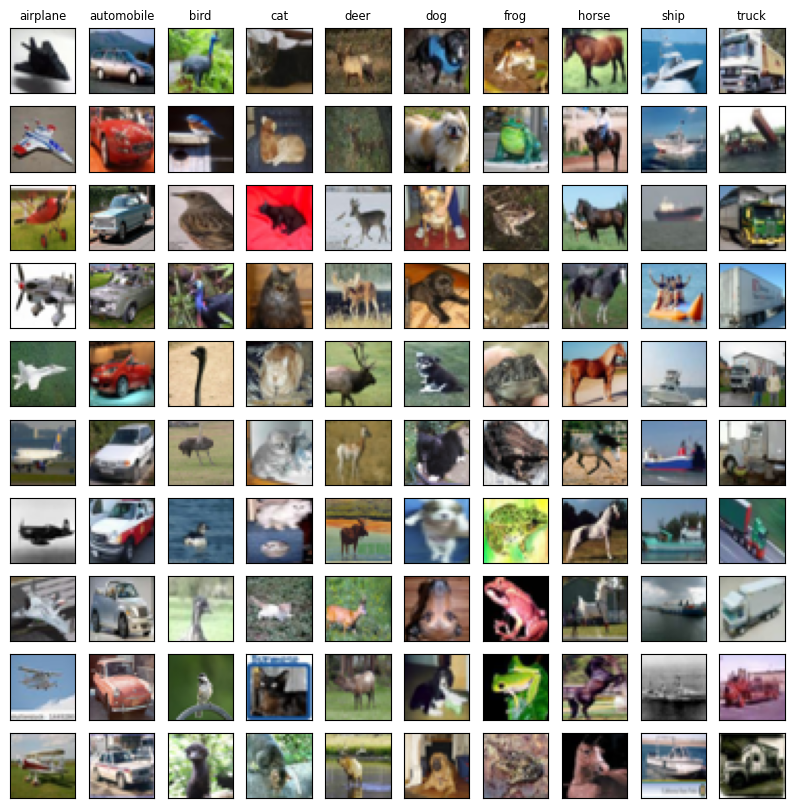

In [5]:
# Hint: To plot example images, you can use the plot examples function
plot_examples(x_train, y_train)

In [6]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# Hint: normalize the data
# Normalize
x_train_norm = x_train / 255
x_test_norm = x_test / 255

# Hint: use 20% of the training data for validation
x_valid_norm = x_test_norm[8000:]
x_test_norm = x_test_norm[:8000]

print("x_train shape:", x_train_norm.shape)
print(x_train_norm.shape[0], "train samples")
print(x_valid_norm.shape[0], "validation samples")
print(x_test_norm.shape[0], "test samples")
print("\ny_train shape:", y_train.shape)
print(y_train_onehot.shape[0], "train samples")
print(y_valid_onehot.shape[0], "validation samples")
print(y_test_onehot.shape[0], "test samples")

x_train shape: (50000, 32, 32, 3)
50000 train samples
2000 validation samples
8000 test samples

y_train shape: (50000, 1)
50000 train samples
2000 validation samples
8000 test samples


In [7]:
# reshape the image matrices to vectors
x_train_norm = x_train_norm.reshape(-1, 32**2*3)
x_valid_norm = x_valid_norm.reshape(-1, 32**2*3)
x_test_norm = x_test_norm.reshape(-1, 32**2*3)
print("x_train shape:", x_train_norm.shape)

x_train shape: (50000, 3072)


We start with a fully connected network

In [8]:
# We try to select the best for it...
N = 20 # number of trials
search = {
    'batch_size': np.random.choice([16, 32, 64, 128, 256], N),
    'learn_rate': np.random.choice([-5,-4, -3, -2, -1],N),
    'activation': np.random.choice(['relu', 'elu', 'sigmoid', 'tanh'], N),
    'dropout': np.random.choice([0.0, 0.1, 0.2, 0.3, 0.5, 0.6], N),
    'val_acc': np.zeros(N)
}

for i in range(N):
  # you can access the current value of the hyperparameter with `search['batch_size'][i]`
  model = tf.keras.models.Sequential([
                      tf.keras.layers.Dense(256, activation = search['activation'][i], input_shape=(3072,)),
                      tf.keras.layers.Dense(256, activation = search['activation'][i], input_shape=(3072,)),
                      tf.keras.layers.Dropout(search['dropout'][i]),
                      tf.keras.layers.Dense(10, activation='softmax')])
  model.compile(loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1*10**int(search['learn_rate'][i])), metrics=['accuracy'])
  results = model.fit(
        x_train_norm, y_train_onehot,
        validation_data=(x_valid_norm, y_valid_onehot),
        batch_size=search['batch_size'][i],
        epochs=10,
        verbose=0
      )
  search['val_acc'][i] = model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=128)[1]
  print(f"iteration {i}:")
  for key in search:
    print(f"\t{key}: {search[key][i]}")
  print(f"\t-> accuracy {search['val_acc'][i]:.3f}, error rate = {100*(1-search['val_acc'][i]):.1f}%")

2025-11-19 09:05:59.236156: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


iteration 0:
	batch_size: 128
	learn_rate: -1
	activation: tanh
	dropout: 0.3
	val_acc: 0.0988750010728836
	-> accuracy 0.099, error rate = 90.1%
iteration 1:
	batch_size: 16
	learn_rate: -3
	activation: elu
	dropout: 0.0
	val_acc: 0.47712498903274536
	-> accuracy 0.477, error rate = 52.3%
iteration 2:
	batch_size: 256
	learn_rate: -5
	activation: elu
	dropout: 0.0
	val_acc: 0.3922500014305115
	-> accuracy 0.392, error rate = 60.8%
iteration 3:
	batch_size: 128
	learn_rate: -4
	activation: sigmoid
	dropout: 0.1
	val_acc: 0.4282500147819519
	-> accuracy 0.428, error rate = 57.2%
iteration 4:
	batch_size: 32
	learn_rate: -4
	activation: tanh
	dropout: 0.1
	val_acc: 0.4937500059604645
	-> accuracy 0.494, error rate = 50.6%
iteration 5:
	batch_size: 64
	learn_rate: -4
	activation: sigmoid
	dropout: 0.2
	val_acc: 0.4377500116825104
	-> accuracy 0.438, error rate = 56.2%
iteration 6:
	batch_size: 256
	learn_rate: -3
	activation: sigmoid
	dropout: 0.6
	val_acc: 0.46537500619888306
	-> accurac

After some playing, trying to improve as much as possible the NN, we arrive to the following setup:

In [9]:
nb_nodes = 256
activation = "relu"
output = 10
drop_rate = 0.25 # Between 0.2 and 0.5

model = tf.keras.models.Sequential([
    layers.Dense(nb_nodes, activation=activation, input_shape=(3072,)),
    layers.Dense(nb_nodes, activation=activation, input_shape=(3072,)),
    layers.Dropout(drop_rate), 
    layers.Dense(output), # output
    # softmax activation to transform output into probabilities
    layers.Activation('softmax')])
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    # the recommended loss
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # For M1/M2 macs works better
    metrics=['accuracy']
)

model.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=128,
    epochs=20,
    verbose=2,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
391/391 - 1s - loss: 1.8969 - accuracy: 0.3139 - val_loss: 1.7561 - val_accuracy: 0.3535 - 1s/epoch - 4ms/step
Epoch 2/20
391/391 - 1s - loss: 1.7157 - accuracy: 0.3855 - val_loss: 1.6526 - val_accuracy: 0.4165 - 1s/epoch - 3ms/step
Epoch 3/20
391/391 - 1s - loss: 1.6363 - accuracy: 0.4175 - val_loss: 1.6039 - val_accuracy: 0.4385 - 1s/epoch - 3ms/step
Epoch 4/20
391/391 - 1s - loss: 1.5918 - accuracy: 0.4353 - val_loss: 1.5701 - val_accuracy: 0.4395 - 1s/epoch - 3ms/step
Epoch 5/20
391/391 - 1s - loss: 1.5586 - accuracy: 0.4479 - val_loss: 1.5534 - val_accuracy: 0.4585 - 1s/epoch - 3ms/step
Epoch 6/20
391/391 - 1s - loss: 1.5215 - accuracy: 0.4605 - val_loss: 1.5223 - val_accuracy: 0.4565 - 1s/epoch - 3ms/step
Epoch 7/20
391/391 - 1s - loss: 1.4999 - accuracy: 0.4689 - val_loss: 1.5043 - val_accuracy: 0.4740 - 1s/epoch - 3ms/step
Epoch 8/20
391/391 - 1s - loss: 1.4711 - accuracy: 0.4780 - val_loss: 1.4945 - val_accuracy: 0.4585 - 1s/epoch - 3ms/step
Epoch 9/20
391/391 - 1s 

In [10]:
print("Model performance :")
headers = ["", "Loss", "Accuracy", "Test error rate [%]"]

table = [
    [
        "Train",
        *model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Validation",
        *model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=nb_nodes)[1])
        * 100,
    ],
    [
        "Test",
        *model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=nb_nodes),
        (1 - model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=nb_nodes)[1]) * 100,
    ],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |    Loss |   Accuracy |   Test error rate [%] |
|------------+---------+------------+-----------------------|
| Train      | 1.24524 |     0.5594 |                 44.06 |
| Validation | 1.40945 |     0.495  |                 50.5  |
| Test       | 1.3767  |     0.513  |                 48.7  |


In [ ]:


# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots()
ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch")
ax.grid(True)
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

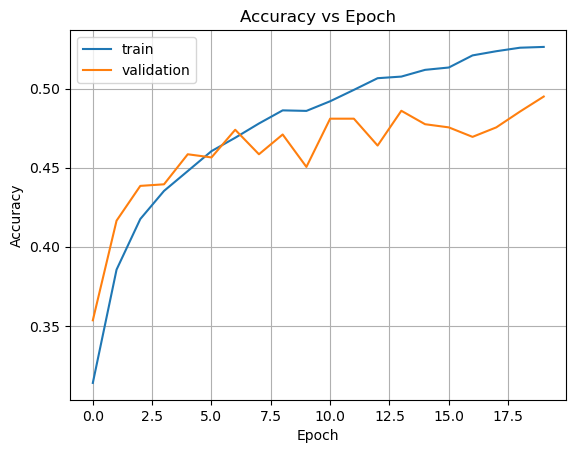

In [11]:
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots()
ax.plot(history['accuracy'])
ax.plot(history['val_accuracy'])
ax.set(xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch")
ax.grid(True)
ax.legend(['train', 'validation'], loc='upper left')

plt.show()

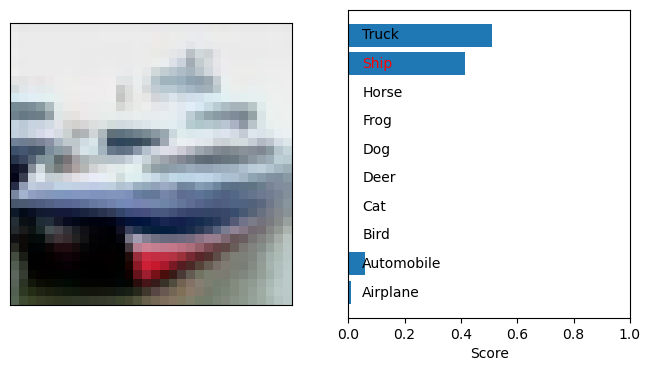

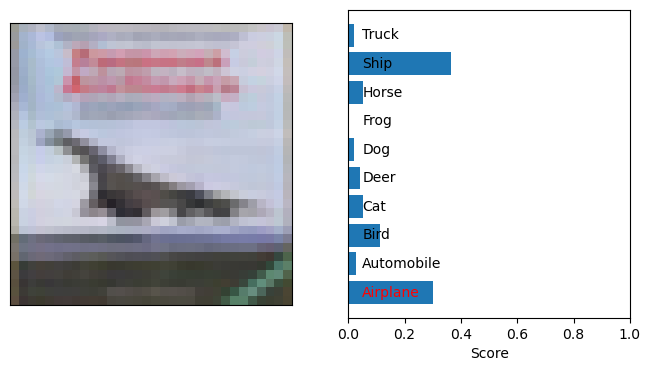

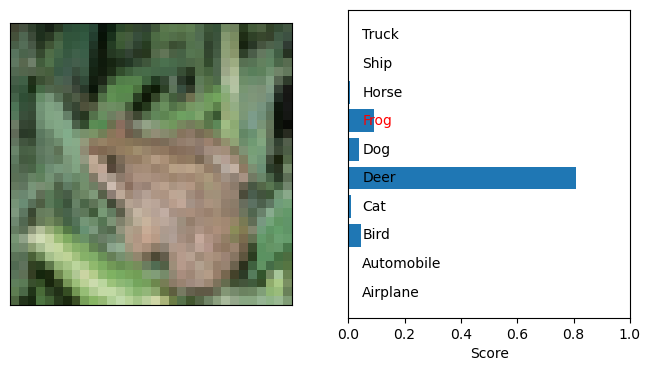

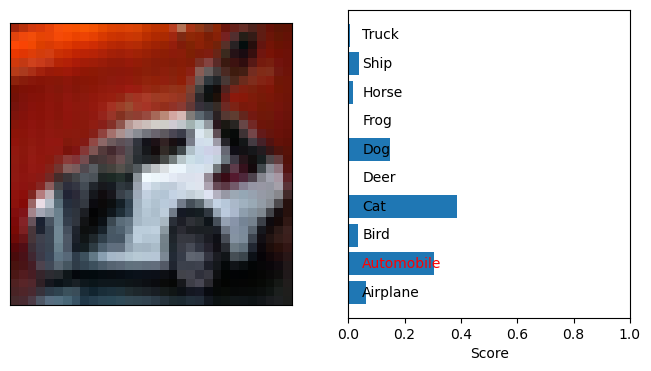

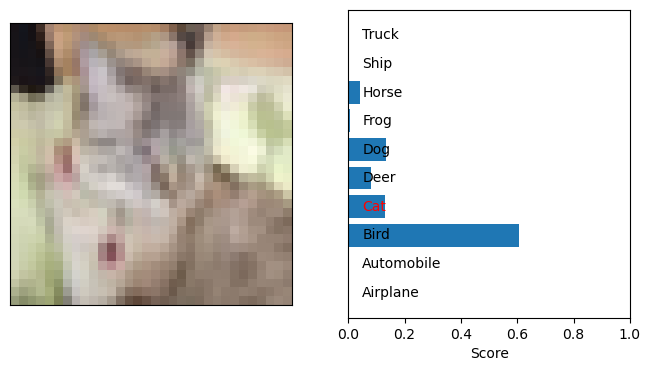

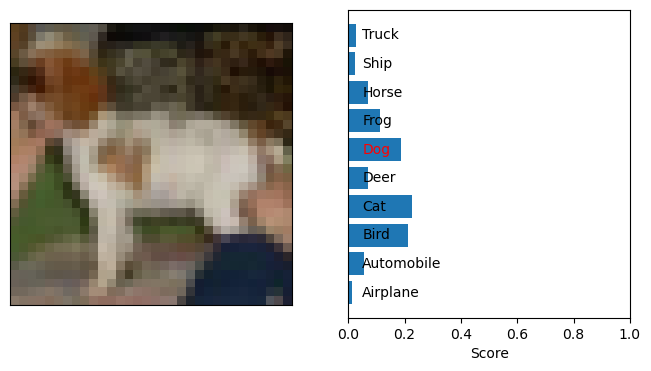

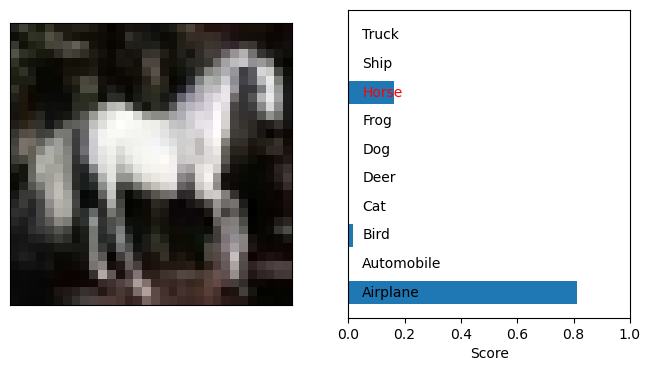

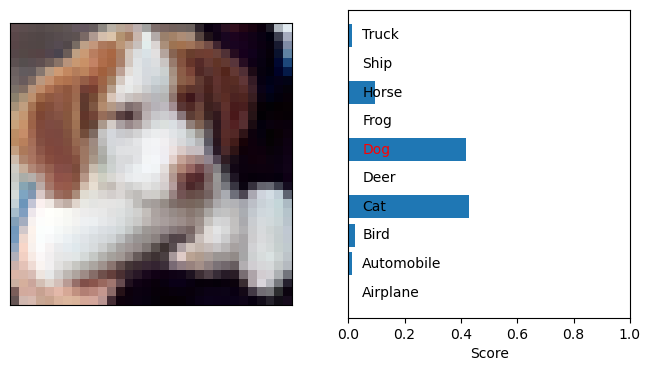

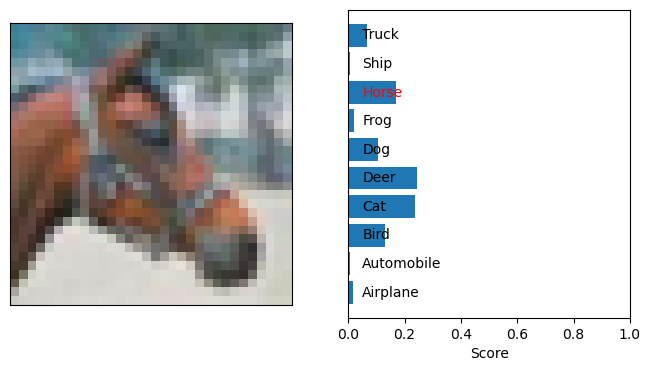

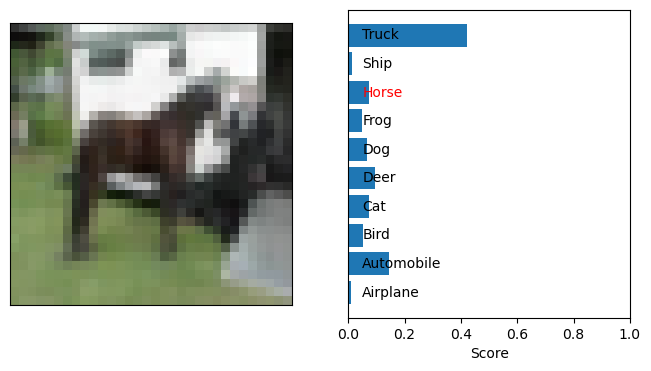

In [12]:
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128, verbose=0)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

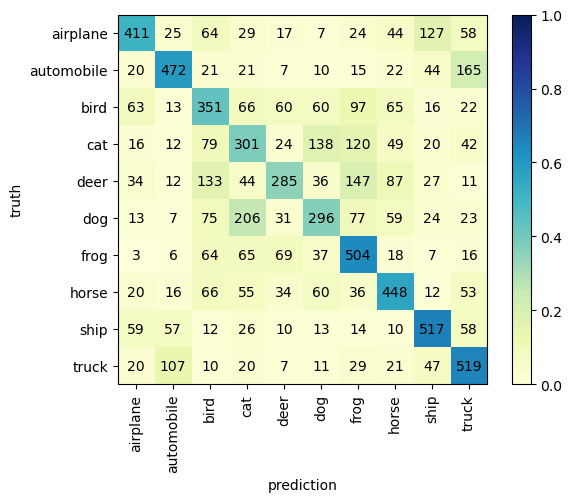

In [13]:
# Hint: this is how you can plot the confusion matrix.

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

**CNN**
In the second part of this exercise, classify the images with a CNN.


In [ ]:
# Hint: this code snipped shows how to define convolution and maxpooling layers. For more information see
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        ... # add additional convolution layer and max pooling layer here,
        layers.Flatten(),
        ... # add dropout and output layer
    ],
    name="cnn",
)

print(model.summary())

In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
...
)

model.fit(
    ...
    batch_size=..,
    epochs=40,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)